# Evidential Model for Classification
The evidential model is based on https://arxiv.org/pdf/1806.01768.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from tqdm import tqdm

from probly.quantification.classification import evidential_uncertainty
from probly.train.evidential.torch import EvidentialKLDivergence, EvidentialLogLoss
from probly.transformation.evidential.classification import evidential_classification

In [2]:
train = torchvision.datasets.FashionMNIST(root="~/datasets", train=True, download=True, transform=T.ToTensor())
test = torchvision.datasets.FashionMNIST(root="~/datasets", train=False, download=True, transform=T.ToTensor())
train_loader = DataLoader(train, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

In [3]:
class LeNet(nn.Module):
    """Implementation of a model with LeNet architecture.

    Attributes:
        conv1: nn.Module, first convolutional layer
        conv2: nn.Module, second convolutional layer
        fc1: nn.Module, first fully connected layer
        fc2: nn.Module, second fully connected layer
        act: nn.Module, activation function
        max_pool: nn.Module, max pooling layer
    """

    def __init__(self) -> None:
        """Initializes an instance of the LeNet class."""
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        self.act = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the LeNet.

        Args:
            x: torch.Tensor, input data
        Returns:
            torch.Tensor, output data
        """
        x = self.act(self.max_pool(self.conv1(x)))
        x = self.act(self.max_pool(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x


net = LeNet()

In [4]:
model = evidential_classification(net)
print(model)

Sequential(
  (0): LeNet(
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (act): ReLU()
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Softplus(beta=1.0, threshold=20.0)
)


In [5]:
optimizer = optim.Adam(model.parameters())
criterion = EvidentialLogLoss()
regularization = EvidentialKLDivergence()
for epoch in tqdm(range(20)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        lmbda = min(1.0, epoch / 10)
        loss = criterion(outputs, targets) + lmbda * regularization(outputs, targets)
        loss.backward()
        optimizer.step()

# compute accuracy on test set
correct = 0
total = 0
model.eval()
for inputs, targets in test_loader:
    outputs = model(inputs)
    correct += (outputs.argmax(1) == targets).sum()
    total += targets.size(0)
print(f"Accuracy: {correct / total}")

100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


Accuracy: 0.8478999733924866


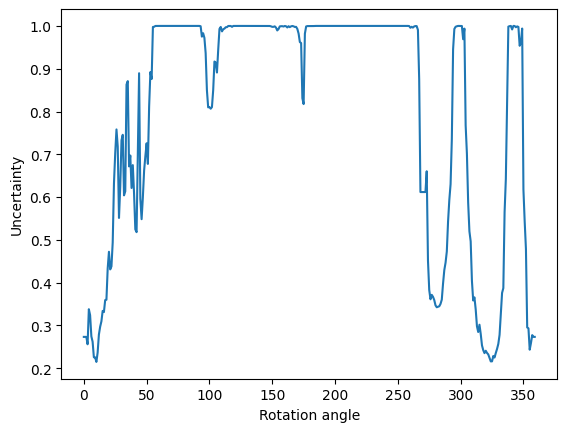

In [6]:
# rotate image from the test set and compute the uncertainty
image = test[0][0]
images = []
for angle in range(0, 360, 1):
    images.append(T.functional.rotate(image, angle))
images = torch.stack(images)
preds = model(images).detach().cpu().numpy()
uncertainties = evidential_uncertainty(preds)
plt.plot(range(0, 360, 1), uncertainties)
plt.xlabel("Rotation angle")
plt.ylabel("Uncertainty")
plt.show()